source: http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/18/image-segmentation-with-tensorflow-using-cnns-and-conditional-random-fields/

depedency to run:
    TF: 0.12
    pydensecrf: https://github.com/lucasb-eyer/pydensecrf    

In [7]:
'''
Input: raw RGB image, it is a (320, 576, 3) numpy array
       predicted probability for each pixel: (1,320,576,2) array. (two class including background)
       true annotation: annotation for each pixel. (320,576,1) array
       
Output: (320,576) array of class label for each pixel

'''

'\nInput: raw RGB image, it is a (320, 576, 3) numpy array\n       predicted probability for each pixel: (1,320,576,2) array. (two class including background)\n       true annotation: annotation for each pixel. (320,576,1) array\n       \nOutput: (320,576) array of class label for each pixel\n\n'

In [8]:
import numpy as np
from matplotlib import pyplot as plt

import skimage.io as io
import sys
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary

In [9]:


image = np.load("../data/image.npy")
final_probabilities = np.load("../data/pred_prob.npy")
true_annotation = np.load("../data/true_annotation.npy")
final_probabilities.shape

(1, 320, 576, 2)

In [10]:
softmax = final_probabilities.squeeze()

softmax = softmax.transpose((2, 0, 1))

# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = softmax_to_unary(softmax)

# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)


In [11]:

d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)

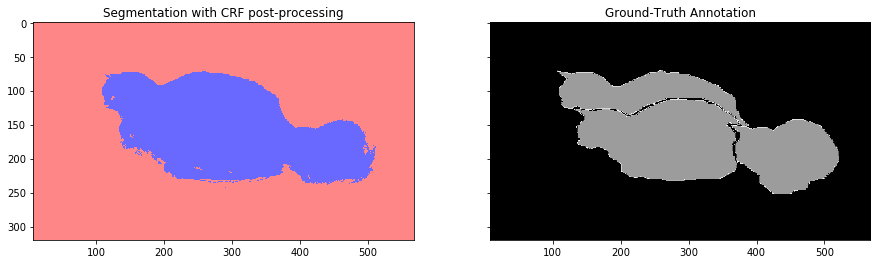

In [12]:
fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')

probability_graph = ax2.imshow(np.dstack((true_annotation,)*3)*100)
ax2.set_title('Ground-Truth Annotation')
plt.show()
